# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                      'case=1_single_image_small'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_image_small with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
  orthogonality:
    scale: 0.0



{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
cfg.case.user.data_idx = 2
cfg.case.model='ConvNetSmall'

cfg.case.user.num_data_points = 10
cfg.case.server.model_state = 'orthogonal'
# The total variation scale should be small for CIFAR images
cfg.attack.regularization.total_variation.scale = 1e-4

cfg.attack.objective.type='masked-cosine-similarity'
cfg.attack.optim.signed=False

### Instantiate all parties

In [4]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Model architecture <class 'breaching.cases.models.model_preparation.ConvNetSmall'> loaded with 15,355,402 parameters and 0 buffers.
Overall this is a data ratio of     500:1 for target shape [10, 3, 32, 32] given that num_queries=1.


In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 10
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ConvNetSmall
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 2
        


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
[(g.mean(), g.std()) for g in shared_data['gradients'][0]]

[(tensor(9.6411e-05, device='cuda:0'), tensor(0.0021, device='cuda:0')),
 (tensor(6.4138e-05, device='cuda:0'), tensor(0.0023, device='cuda:0')),
 (tensor(-3.0526e-06, device='cuda:0'), tensor(0.0006, device='cuda:0')),
 (tensor(-5.0438e-05, device='cuda:0'), tensor(0.0024, device='cuda:0')),
 (tensor(2.6643e-06, device='cuda:0'), tensor(0.0005, device='cuda:0')),
 (tensor(-9.0698e-06, device='cuda:0'), tensor(0.0028, device='cuda:0')),
 (tensor(7.3224e-06, device='cuda:0'), tensor(0.0006, device='cuda:0')),
 (tensor(7.0766e-05, device='cuda:0'), tensor(0.0057, device='cuda:0')),
 (tensor(1.1942e-10, device='cuda:0'), tensor(0.0077, device='cuda:0')),
 (tensor(2.2352e-09, device='cuda:0'), tensor(0.1050, device='cuda:0'))]

In [7]:
torch.stack([g.pow(2).sum() for g in shared_data['gradients'][0][:-4]]).sum().sqrt()

tensor(1.2273, device='cuda:0')

['ship', 'dog', 'deer', 'deer', 'dog', 'airplane', 'frog', 'ship', 'automobile', 'ship']


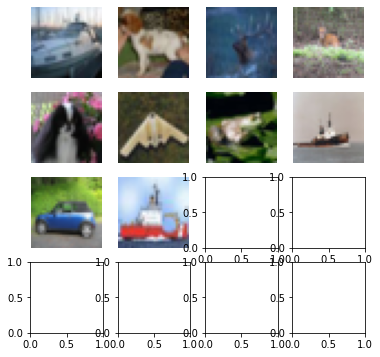

In [8]:
user.plot(true_user_data)

In [11]:
results = breaching.analysis.metrics.gradient_uniqueness(user.model, user.loss, true_user_data, 
                                                            server_payload, setup, fudge=1e-5)
unique_entries, average_hits_per_entry, nonzero_uniques, nonzero_hits_per_entry, uniques, uniques_nonzero = results
print(f'Unique entries (hitting 1 or all): {unique_entries:.2%}, average hits: {average_hits_per_entry:.2%} \n'
      f'Stats (as N hits:val): {dict(zip(uniques[0].tolist(), uniques[1].tolist()))}\n'
      f'Unique nonzero (hitting 1 or all): {nonzero_uniques:.2%} Average nonzero: {nonzero_hits_per_entry:.2%}. \n'
      f'nonzero-Stats (as N hits:val): {dict(zip(uniques_nonzero[0].tolist(), uniques_nonzero[1].tolist()))}')

Unique entries (hitting 1 or all): 18.04%, average hits: 142.46% 
Stats (as N hits:val): {0: 11300416, 1: 1491263, 2: 265257, 3: 99284, 4: 81472, 5: 87003, 6: 103747, 7: 130224, 8: 188497, 9: 329605, 10: 1278634}
Unique nonzero (hitting 1 or all): 10.90% Average nonzero: 14.63%. 
nonzero-Stats (as N hits:val): {0: 11202844, 1: 1398151, 2: 190580, 3: 26977, 4: 3472, 5: 414, 6: 44, 7: 3}


In [ ]:
# sparsity
(shared_data['gradients'][0][0].abs() > 1e-7).sum() / shared_data['gradients'][0][0].numel()

### Reconstruct user data:

In [ ]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

In [ ]:
user.plot(reconstructed_user_data)

In [ ]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=True)